In [ ]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


In [11]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [12]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False)
model.to(device)
model.eval()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

0_label5.png: Pred: 1, Label: 5
1_label3.png: Pred: 1, Label: 3
2_label3.png: Pred: 1, Label: 3
3_label7.png: Pred: 3, Label: 7
4_label2.png: Pred: 6, Label: 2


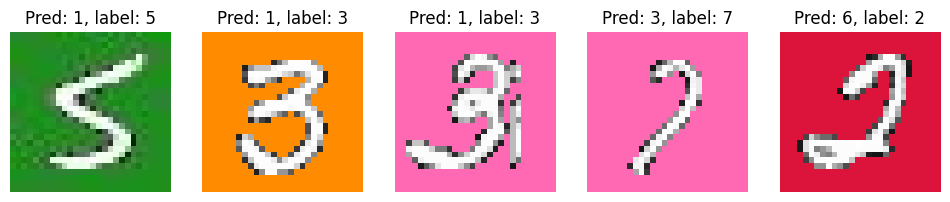

In [ ]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

SALIENCY MAPS

In [ ]:
# Funciones necesarias luego
def predict_np(img_np):
    """ img_np: numpy array HWC [0,1] """
    img_t = torch.from_numpy(img_np.transpose(2,0,1)).unsqueeze(0).float().to(device)
    with torch.no_grad():
        pred = int(model(img_t).argmax(dim=1).item())
    return pred

In [ ]:
def grad_norm_on_input(model, x, y_idx):
    x = x.clone().detach().requires_grad_(True)
    logits = model(x)
    target = logits[0, y_idx]
    model.zero_grad(set_to_none=True)
    target.backward()
    g = x.grad.detach().view(-1)
    return float(torch.linalg.vector_norm(g, ord=2).cpu())

In [ ]:
def saliency_true_logit(model, x, y_idx):
    """
    Saliency respecto al LOGIT de la clase correcta: |∇_x logit_y|.
    x: (1,C,28,28) en [0,1]
    """
    x = x.clone().detach().requires_grad_(True)
    logits = model(x)                 # pre-softmax
    target = logits[0, y_idx]
    model.zero_grad(set_to_none=True)
    target.backward()
    g = x.grad.detach().abs()[0]      # (C,H,W)
    if g.shape[0] > 1:
        g = g.mean(dim=0)
    else:
        g = g[0]
    g = g - g.min()
    g = g / (g.max() + 1e-8)
    return g.cpu().numpy()            # (H,W) en [0,1]


In [ ]:
def show_saliency_for_file(img_path, target="true", overlay=True, cmap="inferno"):
    """
    target: "true" usa la clase del nombre de archivo (último dígito del stem),
            "pred" usa la clase que predice el modelo en crudo.
    overlay: si True, superpone el saliency semitransparente sobre el gris.
    """
    # Carga y tensor
    img28 = Image.open(img_path).convert("RGB").resize((28,28))
    x = to_tensor(img28).unsqueeze(0).to(device)  # (1,C,28,28) en [0,1]
    H, W = x.shape[-2:]

    # Etiquetas y gradiente
    with torch.no_grad():
        logits = model(x)
        pred = int(output.argmax(dim=1).item())
        probs = torch.softmax(logits, dim=1).cpu().numpy() 

    true_label = int(Path(img_path).stem[-1])
    y_idx = true_label if target == "true" else pred

    s_map = saliency_true_logit(model, x, y_idx)       # (H,W) en [0,1]
    gnorm = grad_norm_on_input(model, x, y_idx)

    # Plots
    fig, axes = plt.subplots(1, 3 if overlay else 2, figsize=(12, 4))
    ax0 = axes[0]; ax1 = axes[1]
    ax0.imshow(img28.convert("L"), cmap="gray", vmin=0, vmax=255)
    ax0.set_title(f"Original\npred={pred} (true={true_label})")
    ax0.axis("off")

    ax1.imshow(s_map, cmap=cmap)
    ax1.set_title(f"Saliency |∇ logit_{y_idx}|\n‖grad‖={gnorm:.2e}")
    ax1.axis("off")

    if overlay:
        ax2 = axes[2]
        ax2.imshow(img28.convert("L"), cmap="gray", vmin=0, vmax=255)
        ax2.imshow(s_map, cmap=cmap, alpha=0.45)
        ax2.set_title("Overlay")
        ax2.axis("off")

    plt.suptitle(f"{Path(img_path).name}  —  objetivo: {y_idx} ({'true' if target=='true' else 'pred'})")
    plt.tight_layout()
    plt.show()

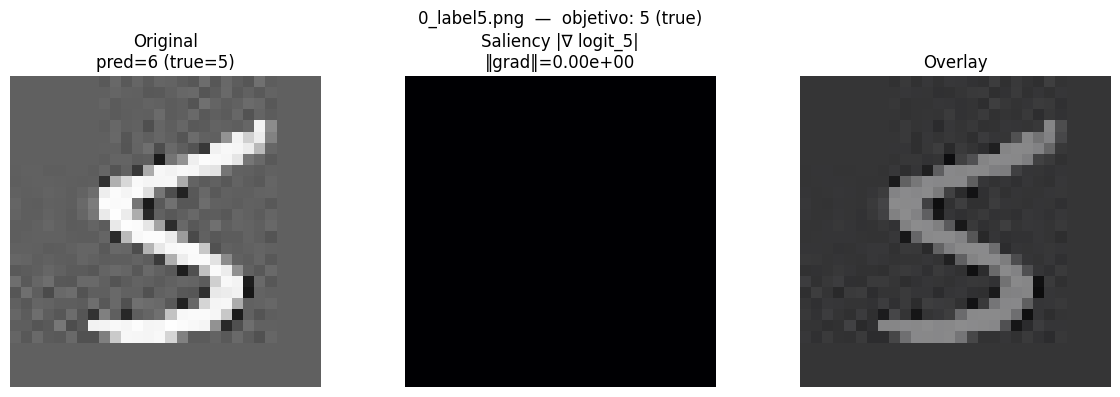

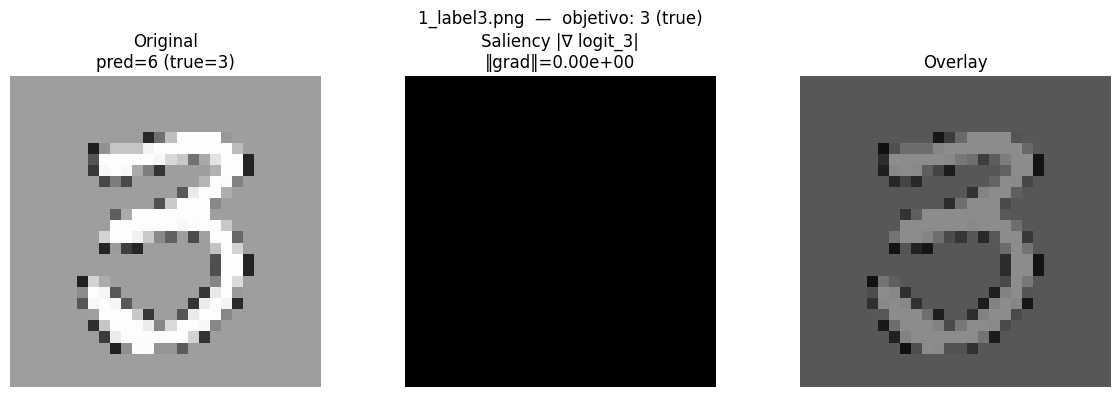

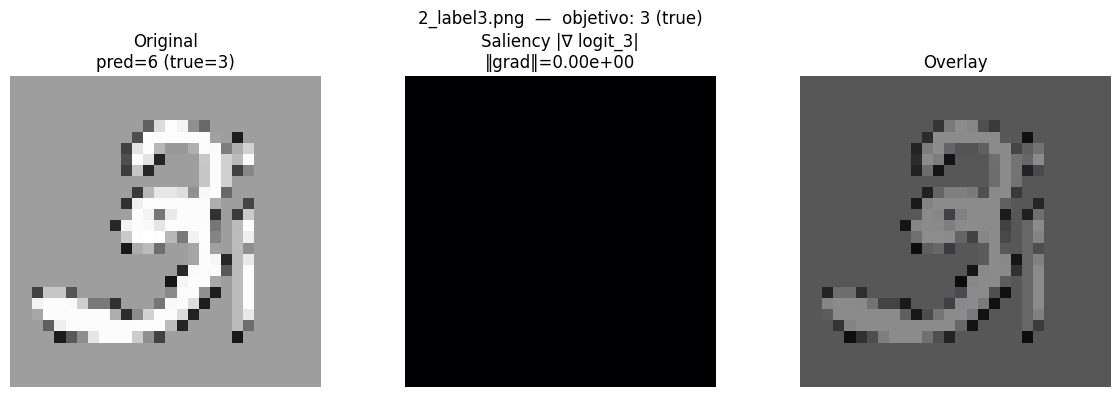

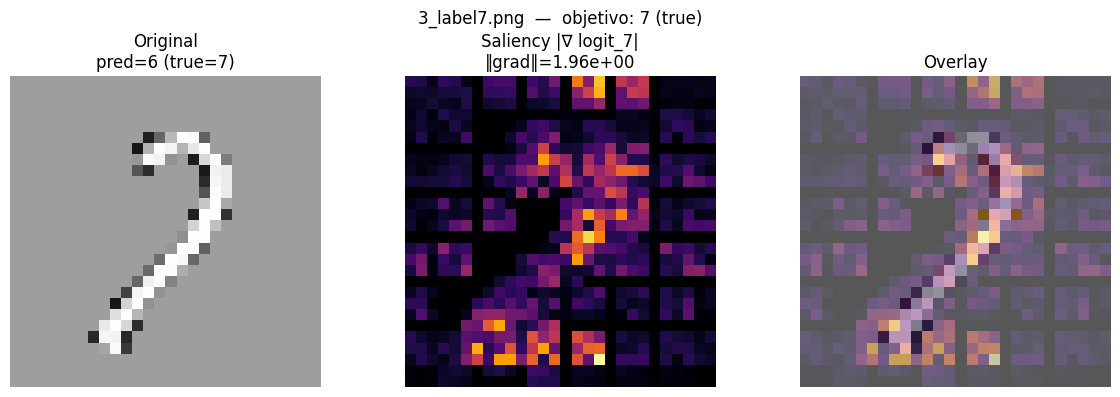

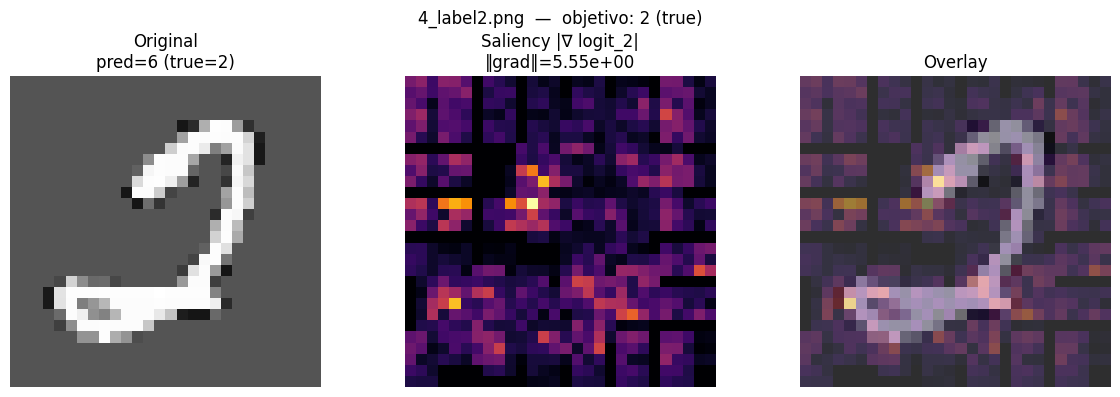

In [ ]:
# Cambia el nombre a cualquiera de tu carpeta
one_file = Path("../data/MNIST/challenge/")  # ajusta si tu ruta es distinta
files = sorted(one_file.glob("*.png"))
for f in files:
    show_saliency_for_file(f, target="true", overlay=True)

No todas las imagenes tienen gradientes significativos, por lo que hace que los métodos basados en gradientes no funcionen bien. Para las dos imagenes con saliency maps útiles, vamos a probar a cambiar a editar las imagenes para que prediga bien la clase correcta.

In [ ]:
def edit_with_saliency_minimal(img_pil, true_label, top_pct=0.15, darken_amt=0.30):
    """
    Edita SOLO dentro de la máscara top-k del saliency del logit verdadero:
      A) borrar ruido claro (llevar a blanco)
      B) reforzar trazo (oscurecer un poco)
    Devuelve (edited_np_uint8, pred_before, pred_after)
    """
    img28 = img_pil.convert("RGB").resize((28,28), Image.BILINEAR)
    x = to_tensor(img28).unsqueeze(0).to(device)

    # saliency & mask
    s_map = saliency_true_logit(model, x, true_label)  # (H,W) en [0,1]
    th = np.percentile(s_map, 100*(1 - top_pct))
    mask = (s_map >= th).astype(np.float32)  # (H,W) {0,1}

    # a numpy [0,1]
    arr = (np.array(img28).astype(np.float32) / 255.0)
    pred0 = predict_np(arr)
    
    # PASO A: borrar ruido claro dentro de la máscara
    outA = arr.copy()
    bright = (outA.mean(axis=2) > 0.6).astype(np.float32)
    mA = (mask * bright)[:, :, None]
    outA = outA*(1 - mA) + 1.0*mA
    predA = predict_np(outA)

    if predA == true_label:
        return (outA*255).astype(np.uint8), pred0, predA

    # PASO B: reforzar trazo oscuro dentro de la máscara
    outB = outA.copy()
    dark = (outB.mean(axis=2) < 0.5).astype(np.float32)
    mB = (mask * dark)[:, :, None]
    outB = np.clip(outB - darken_amt*mB, 0, 1)
    predB  = predict_np(outB)
    
    return (outB*255).astype(np.uint8), pred0, predB

In [ ]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [ ]:
def try_fix_with_saliency(img_path, top_pcts=(0.12, 0.18, 0.24), darken_amt=0.30, grad_min=1e-6):
    """
    Intenta corregir una imagen usando saliency si hay gradiente suficiente.
    Devuelve dict con resultado y guarda en .../edited/ si es válido.
    """
    edited_dir = img_path.parent / "edited"
    edited_dir.mkdir(parents=True, exist_ok=True)

    img_pil = Image.open(img_path).convert("RGB")
    true_label = int(Path(img_path).stem.split("label")[-1][0])  # último dígito del stem

    # mide norma de gradiente (respecto al logit de la clase verdadera)
    x28 = to_tensor(img_pil.convert("RGB").resize((28,28), Image.BILINEAR)).unsqueeze(0).to(device)
    gnorm = grad_norm_on_input(model, x28, true_label)

    if gnorm < grad_min:
        # sin gradiente útil: no intentamos saliency aquí
        return {"ok": False, "skipped": False, "reason": "vanishing_gradients", "grad_norm": gnorm}

    best = None
    for tp in top_pcts:
        edited_np, pred_before, pred_after = edit_with_saliency_minimal(img_pil, true_label, top_pct=tp, darken_amt=darken_amt)
        edited = Image.fromarray(edited_np)

        p = calculate_edit_percentage(img_pil, edited)
        edited_np = (np.array(edited).astype(np.float32) / 255.0)
        pred_final = predict_np(edited_np)
    
        logline = f"{img_path.name} | before={pred_before} -> after={pred_final} | true={true_label} | edit%={p:.1f} | top_pct={tp} | grad_norm={gnorm:.2e}"
        print(logline)

        if (pred_final == true_label) and (p <= 40.0):
            edited.save(edited_dir / img_path.name)
            best = {"ok": True, "pred_before": pred_before, "pred_after": pred_final,
                    "edit_pct": p, "top_pct": tp, "grad_norm": gnorm}
            break

    if best is None:
        best = {"ok": False, "pred_before": pred_before, "pred_after": pred_final,
                "edit_pct": p, "top_pct": tp, "grad_norm": gnorm}
    return best

In [ ]:
challenge_dir = Path("../data/MNIST/challenge")  # ajusta si tu ruta es otra
files = sorted(challenge_dir.glob("*.png"))

ok = 0
attempted = 0
skipped_grad = 0
for f in files:
    r = try_fix_with_saliency(f, top_pcts=(0.12, 0.18, 0.24), darken_amt=0.30, grad_min=1e-6)
    if r.get("skipped", False):
        continue
    attempted += 1
    if r.get("reason") == "vanishing_gradients":
        skipped_grad += 1
        print(f"  -> saltada (vanishing gradients): {f.name} (‖grad‖={r['grad_norm']:.2e})")
    if r["ok"]:
        ok += 1

print(f"\nHe intentado corregir {attempted} imágenes (saltadas por gradiente: {skipped_grad}).")
print(f"Guardadas válidas (pred correcta y ≤40% editado): {ok}")
print("Se han guardado en:", challenge_dir / "edited")


  -> saltada (vanishing gradients): 0_label5.png (‖grad‖=0.00e+00)
  -> saltada (vanishing gradients): 1_label3.png (‖grad‖=0.00e+00)
  -> saltada (vanishing gradients): 2_label3.png (‖grad‖=0.00e+00)
3_label7.png | before=3 -> after=7 | true=7 | edit%=10.2 | top_pct=0.12 | grad_norm=1.96e+00
4_label2.png | before=6 -> after=2 | true=2 | edit%=2.2 | top_pct=0.12 | grad_norm=5.55e+00

He intentado corregir 5 imágenes (saltadas por gradiente: 3).
Guardadas válidas (pred correcta y ≤40% editado): 2
Se han guardado en: ..\data\MNIST\challenge\edited


Solo hay dos imagenes que se han podido modificar con los saliency maps. Vamos ahora a probar a editar el resto de imagenes usando oclusion y rise a ver si conseguimos mejores resultados.

In [ ]:
# def fix_image_blackbox(img_path, mode="auto", k=0.18, block=3, passes=2):
#     """
#     - Calcula importancia black-box (RISE/Occlusion) respecto a la clase verdadera.
#     - Edita codicioso en top-k.
#     - Guarda si pred correcta y ≤ 40%.
#     """
#     img_pil = Image.open(img_path).convert("RGB")
#     true_label = int(Path(img_path).stem.split("label")[-1][0])
#     x = to_tensor(img_pil.convert("RGB").resize((28,28), Image.BILINEAR)).unsqueeze(0).to(device)

#     # importancia sin gradientes
#     imp = blackbox_importance(model, x, true_label, mode=mode)  # (H,W) en [0,1]

#     # edición
#     img_np = (np.array(img_pil.convert("RGB").resize((28,28))).astype(np.float32)/255.0)
#     pred_before = predict_np(img_np)
#     edited = greedy_edit_blackbox(model, img_np, true_label, imp, k=k, block=block, passes=passes)

#     # verificación
#     pred_after = predict_np(edited)
#     edited_img = Image.fromarray((edited*255).astype(np.uint8))

#     p = calculate_edit_percentage(img_pil, edited_img)
#     print(f"{Path(img_path).name} | before={pred_before} -> after={pred_after} | true={true_label} | edit%={p:.1f} | mode={mode}, k={k}, block={block}")

#     if (pred_after == true_label) and (p <= 40.0):
#         out_dir = Path(img_path).parent / "edited"
#         out_dir.mkdir(parents=True, exist_ok=True)
#         edited_img.save(out_dir / Path(img_path).name)
#         return True, p
#     return False, p

In [ ]:
# challenge_dir = Path("../data/MNIST/challenge")
# files = sorted(challenge_dir.glob("*.png"))

# ok = 0
# for f in files:
#     # salta las que ya corregiste con saliency (si ya existen en edited)
#     if (challenge_dir / "edited" / f.name).exists():
#         continue

#     # Intenta primero RISE (más robusto). Si no entra, prueba Occlusion con k algo mayor.
#     success, pct = fix_image_blackbox(f, mode="rise", k=0.18, block=3, passes=2)
#     if not success:
#         success, pct = fix_image_blackbox(f, mode="occ", k=0.22, block=3, passes=3)
#     if success:
#         ok += 1

# print(f"\nGuardadas válidas (black-box): {ok}")
# print("Se han guardado en:", challenge_dir / "edited")

---
## Check if you have passed the challenge 

In [ ]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [ ]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')


Edited 0_label5.png: Pred: 1, Label: 5, correct: False
Edit Percentage: 27.93%
Edited 1_label3.png: Pred: 1, Label: 3, correct: False
Edit Percentage: 0.00%
Edited 2_label3.png: Pred: 1, Label: 3, correct: False
Edit Percentage: 0.00%
Edited 3_label7.png: Pred: 3, Label: 7, correct: False
Edit Percentage: 0.00%
Edited 4_label2.png: Pred: 6, Label: 2, correct: False
Edit Percentage: 0.00%
